# GSE 512 Midterm
### Samuel Tragesser

In [1]:
# Take care of the preliminary business
import numpy as np
from scipy.linalg import null_space # need this for the ergodic distribution
import pandas as pd  #need Pandas for pretty tables
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.figsize'] = (10,6)

#### 1. Import those data from GDP_cycle.csv.  This is a list of 296 numbers

In [2]:
df = pd.read_csv("GDP_cycle.csv")
df

,Unnamed: 0,cycle
0,1948-01-01,0.020399
1,1948-04-01,0.024428
2,1948-07-01,0.017785
3,1948-10-01,0.006505
4,1949-01-01,-0.019847
...,...,...
291,2020-10-01,-0.016461
292,2021-01-01,-0.005077
293,2021-04-01,0.007303
294,2021-07-01,0.009068


#### 2. Plot and make a histogram with five bins.  Each bin will be a state.  The lowest bin is the Covid state; it only has one observation.

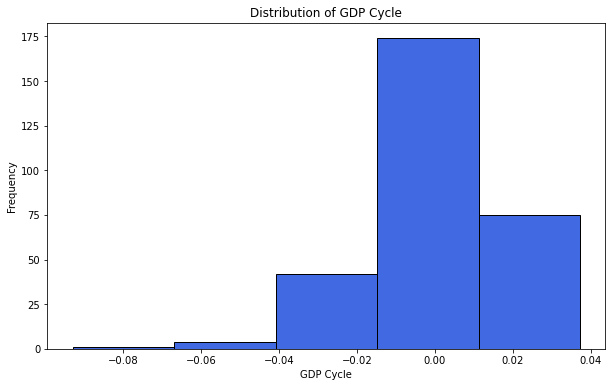

In [3]:
#plot histogram
(counts, bins, patches) = plt.hist(df.cycle, bins=5, color='royalblue', edgecolor='black')

plt.title("Distribution of GDP Cycle")
plt.xlabel("GDP Cycle")
plt.ylabel("Frequency")
plt.show()

#### 3. Classify the states

In [4]:
states = []
for i in df.cycle:
    if i==bins[0]:
        states.append(0)
    if bins[1]<=i<=bins[2]:
        states.append(1)
    if bins[2]<=i<=bins[3]:
        states.append(2)
    if bins[3]<=i<=bins[4]:
        states.append(3)
    if bins[4]<=i<=bins[5]:
        states.append(4)
        
#check if same as Fisher
states[-8:]

[3, 0, 2, 2, 3, 3, 3, 4]

#### 4. Estimate the Markov matrix, and find its ergodic distribution  Report the long-run probability of being in a Covid state.

In [5]:
M_count=np.zeros([5,5])
#Find the count in each row
for i in range(len(states)-1):
    M_count[states[i]][states[i+1]] = M_count[states[i]][states[i+1]] + 1
    

#Estimate Markov matrix
sums = M_count.sum(axis=1)
M = M_count/sums[:, np.newaxis]
M

array([[0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.04761905, 0.64285714, 0.30952381, 0.        ],
       [0.00574713, 0.        , 0.06896552, 0.8045977 , 0.12068966],
       [0.        , 0.        , 0.        , 0.28378378, 0.71621622]])

In [6]:
def ergodic(m):
    """
    This code finds the ergodic distribution of a Markov matrix
    """
    n=m.shape[0] # number of rows
    T = 1000 # useful constant
    eps=0.0001 #useful constant
    if (m.shape[0] != m.shape[1]): #test for a square matrix
        return('Matrix is not square') 
    if (not (np.matmul(m,np.ones(n))==1).all()): #test row sums 
        return('This is not a Markov matrix')
    if( not ((m >= 0).all() and (m <= 1).all())): #test probabilities
        return('This is not a Markov matrix')
    m_long = np.linalg.matrix_power(m,T)
    if( not ((m_long > 0).all() and (m_long < 1).all())): #crude test for aperiodic and irreducible
        return('This matrix may not be both aperiodic and irreducible')
    w,v = np.linalg.eig(m.T) #Need the left eigenvector; that's why we transpose
    choose = (abs(w-1) < eps)
    m_long = v[:,choose]/sum(v[:,choose])  #Need to make the eigenvector into a probability vector.
    return(m_long)

In [7]:
#ergodic distribution of Markov matrix
ergodic_M = ergodic(M)
print("The long-run probability of being in a Covid state is",round(ergodic_M[0][0] * 100,5),"percent." )

The long-run probability of being in a Covid state is 0.33898 percent.


#### 5. Calculate the consumption vector as follows,  First, find the the average value within each bin.  Then raise e to the power of those five numbers. 

In [8]:
#sort data by value
cycle = np.array(df.cycle.sort_values( ascending = True))
#split data into quartiles and compute exp of the mean
c0 = math.exp(np.mean(cycle[0]))
c1 = math.exp(np.mean(cycle[1:5]))
c2 = math.exp(np.mean(cycle[5:47]))
c3 = math.exp(np.mean(cycle[47:221]))
c4 = math.exp(np.mean(cycle[221:]))
#put everything into consumption vector
c = np.array([c0, c1, c2, c3, c4])
print("The consumption in each state is",c)

The consumption in each state is [0.91130092 0.95326013 0.97584011 0.99941257 1.01902903]


#### 6. Here's the asset pricing kernel.  Explain why the diagonal elements are all the same.  Explain also why the matrix is not symmetric.  Explain how the kernel depends upon the Markov matrix. 

In [9]:
#This is the code from 28 Jan 21
# There's no β here.
# This function is used for each row.

def kern(c0,c1,rho):
    """
    This function returns an asset pricing kernel 
    c0 is current consumption
    c1 is the vector of future consumptions
    rho is the inter-temporal elasticity of substitution
    """
    if rho == 1:
        return np.true_divide(1,c1)/(1/c0) 
    else: 
        return np.power(c1,-rho)/c0**(-rho)
    

def mkern(c,beta,rho):
    n = len(c) # number of states
    K=np.zeros((n,n)) # start with an array of zeros
    for i in range (n):
        K[i,:] = beta*kern(c[i],c,rho)  # each row is an asset pricing kernel for consumption in state i
    return(K)
        

In [10]:
# need all of these constants
beta=0.97**(1/4)
rho=2

R = np.ones([5]).T

K=mkern(c,beta,rho)
#check to see if asset pricing kernel is the same as Fisher
K

array([[0.99241412, 0.90697161, 0.86548435, 0.82513865, 0.79367634],
       [1.08590586, 0.99241412, 0.9470185 , 0.90287197, 0.86844571],
       [1.13795909, 1.03998579, 0.99241412, 0.94615142, 0.91007492],
       [1.19360035, 1.09083658, 1.04093886, 0.99241412, 0.95457364],
       [1.24091614, 1.13407869, 1.08220296, 1.03175464, 0.99241412]])

The asset pricing kernel depends on the Markov matrix in that it incorportates the consumption vector, which is an outcome dependant on the probability of landing in each state one period away. The diagonal elements of the asset pricing kernel are the same because an asset will not change in price if there is not a change in states. The elements of lower left triangle of the kernel are greater than 1 because this is discounting for a change in "boom" state to "bust" state. 

#### 7. Here is an array of maturities [1, 2, 4, 8, 20, 40, 80, 120] in quarters.  Make a diagram with five yield curves.  Each line in your diagram should consist of a yield curve in a given state. 

In [11]:
def pricing_T(M,K,R,T):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.
    R is an n x m matrix.  
    There are n states and m assets.
    R(:,j) is the description of asset j
    The asset returns are by column.
    R(i,j) is what asset j pays if state i happens.
    This method returns a n x m matrix P
    P(i,j) is the price of asset j in state i
    This method prices assets that pay out in the period T only
    """
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    M1=np.multiply(M,K) #element-by-elemnt multiplication
    P = np.matmul(np.linalg.matrix_power(M1,T), R)  
    #raise M1 to the T the right multiply by R
    return(P)


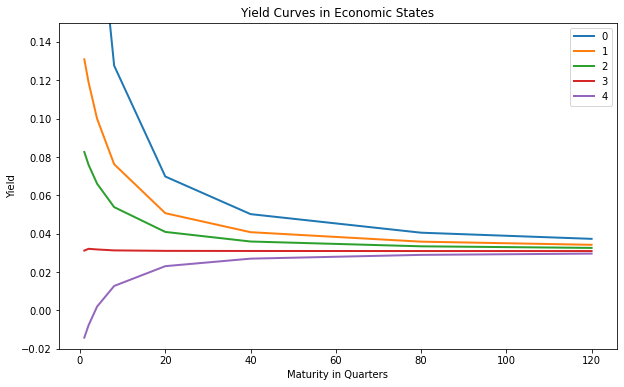

In [12]:
yields = {}
r  = np.array([[1], [1], [1], [1], [1]])
T = np.array([1, 2, 4, 8, 20, 40, 80, 120])
for t in T:
    P = pricing_T(M,K,r,t)
    yields[t] = (1/P[:,0])**(4/t) - 1
yields = pd.DataFrame(yields).transpose()

#Plot yield curves
fig, ax = plt.subplots()
plt.title("Yield Curves in Economic States")
ax.plot(yields, linewidth=2)
ax.set_ylim(-0.02, 0.15)
ax.set_xlabel("Maturity in Quarters")
ax.set_ylabel("Yield")
ax.legend(yields.columns)
plt.show()

#### 8.  Discuss whether an inverted yield curve conveys information about next period's state.

The inverted yield curves in states 0, 1, and 2 indicate that there are higher returns for short term bonds than than long term bonds. Because of the increase sense of panic, people are more likely to seek safer, longer term investments. This causes an increase in the interest rates for short term borrowing to incentive investors to put money in shorter term bonds.

Given we are in lesser state the curves indicate that the consumption is likley to be higher in the next state, meaning that individuals will price out the likelihood of ending up in a more advantageous state in the next period. 

#### 9. The stock market is an asset that pays a dividend equal to the economy's consumption in each quarter.  Price the stock market in each state.  (You can truncate the dividends after 10,000 periods.).

In [13]:
def pricing_stock(M,K,R,T):
    """
    M is a markov matrix
    K is a pricing kernel
    R is an n x T matrix of asset payouts.  
    There are n states and T periods.
    R(:,t) is the description of the dividends promised in period t
    The asset returns are by column.
    R(i,t) is what the asset pays at time t if state i happens.
    This method returns a n x 1 vector p
    p(i) is the price of this sock in state i
    This method prices assets that pay out in the period T only
    T is the end of the payout stream
    """
    n=M.shape[0] #number of states
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    M1=np.multiply(M,K) #element-by-element multiplication
    p=np.zeros(n)
    for t in range(T):
        p += np.matmul(np.linalg.matrix_power(M1,t), R[:,t])  
    #raise M1 to the T the right multiply by t-th column of R
    # Then add them all up
    return(p)

In [14]:
T = 10000
R = np.array([[c[0]]*10000,[c[1]]*10000,[c[2]]*10000,[c[3]]*10000,[c[4]]*10000])
stk_p = pricing_stock(M,K,R,T)
print("The stock prices in each state are",stk_p)

The stock prices in each state are [109.65243393 119.98159553 125.64194044 131.69296797 136.84573899]


#### 10.  The first row of the Markov matrix was (0, 0, 1, 0, 0).  What is the expected duration of a lockdown for this matrix?  Change the first row of the matrix so that it is (p, 0,  1-p, 0, 0) for 0 < p < 1 to simulate a hard four-period lockdown.   What is the correct value of p? 

In [15]:
#The correct value of p is p = 0.75 because it creates a situation where ther expected lockdown is 4 periods.
p = 0.75
M1 = np.array(M)
M1[0] = [p, 0 , 1-p, 0, 0]
ergodic_M1 = ergodic(M1).real
print(" The long-run probability of being in a Covid state is", round(ergodic_M1[0,0],8))

 The long-run probability of being in a Covid state is 0.01342282


#### 11. Simulate and graph the time series of consumption and the stock market for 400 periods  in the two different scenarios, the one-period lockdown and the four-period lockdown.   You should multiply consumption times 100 to put it on the same scale as the stock market.

In [16]:
def simulate(m,x,T):
    """
    This code simulates the outcomes of variable x
    x must be a k x n array of the endogenous variables in each state
    Each endogenous variable x(i,:) has n numbers. x(i,j) is the value of the i-th variable in state j
    m is the n x n Markov matrix that gives transitions between states
    T is the time horizon
    This method needs the method called ergodic to have been compiled
    It returns both the simulated history of states and the simulated random outcomes
    states is a T x 1 vector: s0, s1, ...
    y is a T x 1 vector x(s0), x(s1), ...
    """
    n = m.shape[0] # number of rows of m is the number of states
    k = x.shape[0] # number of endogenous variables
    if x.shape[1] != n:  # check that each variable has n values
        return('The endogenous variables are not in the proper format')
    long_run = ergodic(m).real  # gets the ergodic distribution of m
    s0 = np.random.choice(np.arange(0, n), p=long_run[:,0]) # pick a random inital state using π
    state=[s0] #array showing history of states, starting with the null history
    y = np.zeros((T,k)) 
    y[0,:]=x[:,s0] # initial value of the simulated outcomes
    for t in range(1,T): # we already have used up the null history
        s=np.random.choice(np.arange(0, n), p=m[s0,:]) #choose a random state for next period 
        s0=s #save that new random state
        state.append(s) # append it to the history of states
        y[t,:]= x[:,s] # the t-th row of outcomes is the s-th column of the endogenous variables
    return(state,y)

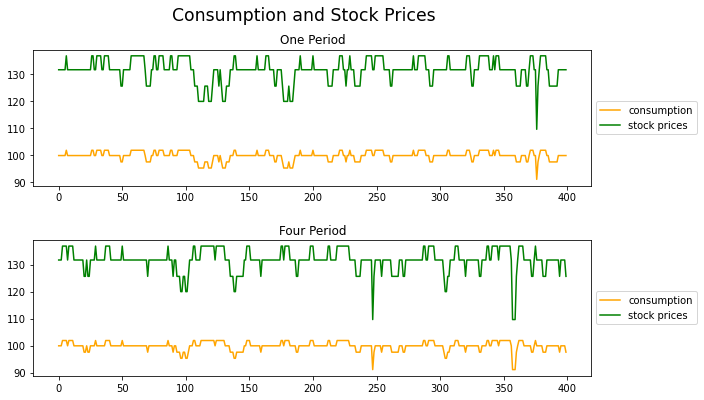

In [17]:
T = 400
x = np.zeros([2,5])
x[0,:]=100*c.T
x[1,:]=stk_p

#Simulate time series of consumption and the stock market for 400 periods
state1,y1 = simulate(M,x,T)
state4,y4 = simulate(M1,x,T)

c1 = y1[:,0]
stock1 = y1[:,1]
c4 = y4[:,0]
stock4 = y4[:,1]

#Graph simulation
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle("Consumption and Stock Prices", size='xx-large')
plt.subplots_adjust( wspace=0.4, hspace=0.4)

ax1.plot(c1, color = 'orange')
ax1.plot(stock1,color='g')
ax1.legend(['consumption','stock prices'],loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_title("One Period")

ax2.plot(c4,color='orange')
ax2.plot(stock4,color='g')
ax2.legend(['consumption','stock prices'],loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title("Four Period")

plt.show()

#### 12.  Calculate the welfare loss from a four-period lockdown as the percentage decrease in long-run average consumption, when comparing a four-period lockdown with a one-period one.  You might want to consider a Rawlsian criterion for welfare loss also; such a criterion would focus on the probability of being in the worst state.    Using this article     https://www.pnas.org/content/117/36/22035  explain if a year-long lockdown was worth it.

In [18]:
# Finding consumption percentage change for the two scenarios
#I worked with Che Lopez on this section
c1_avg=np.mean(c1)
c4_avg=np.mean(c4) #average consumption four period lockdown
print('Percentage change in consumption is',round((c4_avg-c1_avg)/c1_avg*100, 8) )

Percentage change in consumption is 0.03170199


In [19]:
#Utility function
def utility(beta, c, rho):
    util=0
    for i in range(len(c)):
        util += (beta**i)* ((c**(1-rho))/(1-rho))
    return util

In [20]:
# Finding utility for one period lockdown and four period lockdown
util1= utility(beta, c1, rho)

util4= utility(beta, c4, rho)

In [21]:
# Here I will find the welfare loss by taking the difference
diff= util4-util1
print('The average utility in one period lockdown is', np.mean(util1))
print('The average utility in four period lockdown is', np.mean(util4))
print('Welfare loss in utility is', np.mean(diff))

The average utility in one period lockdown is -1.2576240823348803
The average utility in four period lockdown is -1.2572255188900172
Welfare loss in utility is 0.0003985634448632319


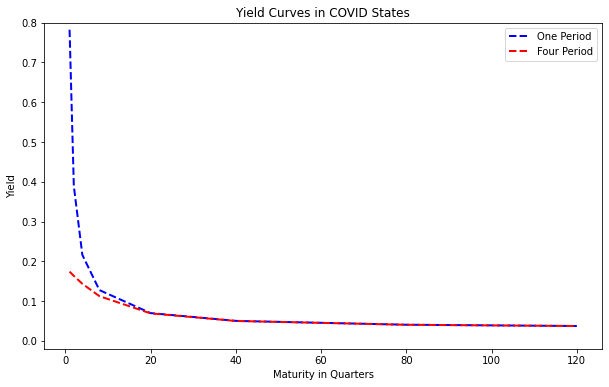

In [22]:
yields1 = {}
r  = np.array([[1], [1], [1], [1], [1]])
T = np.array([1, 2, 4, 8, 20, 40, 80, 120])
for t in T:
    P = pricing_T(M1,K,r,t)
    yields1[t] = (1/P[:,0])**(4/t) - 1
yields1 = pd.DataFrame(yields1).transpose()

#Plot yield curves
fig, ax = plt.subplots()
plt.title("Yield Curves in COVID States")
ax.plot(yields[0],"--", linewidth=2,color='b')
ax.plot(yields1[0],"--", linewidth=2,color='r')
ax.set_ylim(-0.02, 0.80)
ax.set_xlabel("Maturity in Quarters")
ax.set_ylabel("Yield")
ax.legend(["One Period","Four Period"])
plt.show()

The above calculation finds average long-term consumption in an expected four period lockdown to be about 0.3% less than an expected one period lockdown. Assuming a linear function, every additional lockdown period will decrease expected long-term avergage consumption by about 0.1%. However, despite the fact that we only observe a one period lockdown from the observed data, adding an additional period of lockdown would arguably have small effect on longterm consumption.

This is also evident by the changes in the yield curves in the COVID state. The slope in a four period lockdown is greatly less, indicating less optimism for future periods. However, over the long term, both yield curves converge to the same point, indicating that a COVID state has a much greater impact on the short term than the long term.

The article by Goldstein and Lee puts COVID mortality statisics into context with other instances that led to the loss of life. While the article estimates a relatively small loss of life when weighted by expected years remaining in life, there is a large monetary cost to those lives lost. Depending on whether we exist in a world with one period lockdowns or four period lockdowns, the outlook and decison making process on the longterm outlook should not change. The article suggests that there should be care towards saving human life up to a certain point. However, this should only be taken up to a certain point as yields and consumption will converge to stable levels over the long term.